In [1]:
import tensorflow as tf

import pandas as pd
import codecs
import numpy as np
import math
import csv
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import recall_score, precision_score # New
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow.keras.preprocessing
#from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Flatten, Add, Multiply, Subtract
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Activation, BatchNormalization
# regularizers
from tensorflow.keras.layers import Conv1D, Conv2D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dropout, SpatialDropout1D
from scipy import signal
import openpyxl
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns

from keijzer import *
from tensorflow import keras
from keras.models import Model
from keras.layers import *
from tensorflow.keras.optimizers import Adam,SGD
from keras.layers import Dense, Input, Flatten, Add, concatenate, Dropout, Activation, Multiply, Embedding, Layer, Reshape
from keras.layers import LSTM, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D  
from keras.layers import Conv1D, AveragePooling1D, MaxPooling1D
#from keras.ops import convert_to_tensor, convert_to_numpy
#from keras.utils import plot_model
from keras import activations
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
import math

def get_flops(model):
    run_meta = tf.RunMetadata()
    opts = tf.profiler.ProfileOptionBuilder.float_operation()

    # We use the Keras session graph in the call to the profiler.
    flops = tf.profiler.profile(graph=K.get_session().graph,
                                run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops  # Prints the "flops" of the model.

class LossHistory(tensorflow.keras.callbacks.Callback):  # history = LossHistory()
    def init(self):  # history.init()
        self.losses = []
        # self.accs = []
        self.val_losses = []
        # self.val_accs = []
        self.rmses = []
        self.mses = []
        self.maes = []
        self.mapes = []
        self.val_rmses = []
        self.val_mses = []
        self.val_maes = []
        self.val_mapes = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        # self.accs.append(logs.get('acc'))
        self.val_losses.append(logs.get('val_loss'))
        # self.val_accs.append(logs.get('val_accuracy
        self.rmses.append(logs.get('root_mean_squared_error'))
        self.mses.append(logs.get('mean_squared_error'))
        self.maes.append(logs.get('mean_absolute_error'))
        self.mapes.append(logs.get('mean_absolute_percentage_error'))
        self.val_rmses.append(logs.get('val_root_mean_squared_error'))
        self.val_mses.append(logs.get('val_mean_squared_error'))
        self.val_maes.append(logs.get('val_mean_absolute_error'))
        self.val_mapes.append(logs.get('val_mean_absolute_percentage_error'))

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 여러개 사용시 '0,1,2' 식으로 하나의 문자열에 입력
gpus = tf.config.experimental.list_physical_devices('GPU') # 호스트 러나임에 표시되는 GPU 장치 목록 반환

if gpus: # 반환된 GPU 장치 목록이 있다면
    try: # 해당 장치에 대한 메모리 증가 활성화 여부 설정
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e: # try문 실패시에 에러문구 출력
        print(e)

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2020.csv'
data_source1 = pd.read_csv(data_path)
dat_source1 = pd.DataFrame(data_source1)
#dat_source1 = dat_source1.iloc[:-3,:]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2021.csv'
data_source2 = pd.read_csv(data_path)
dat_source2 = pd.DataFrame(data_source2)
dat_source2 = dat_source2.iloc[:8761,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2022.csv'
data_source3 = pd.read_csv(data_path)
dat_source3 = pd.DataFrame(data_source3)
dat_source3 = dat_source3.iloc[:8760,:9]

data_path = 'C:/Users/smartgrid_AI/Desktop/windpower_ramprate/ercot_2023.csv'
data_source4 = pd.read_csv(data_path)
dat_source4 = pd.DataFrame(data_source4)
dat_source4 = dat_source4.iloc[:8760,:9]

dat_arr1 = np.array(dat_source1)
dat_arr2 = np.array(dat_source2)
dat_arr3 = np.array(dat_source3)
dat_arr4 = np.array(dat_source4)

dat_arr = np.concatenate([dat_arr1, dat_arr2, dat_arr3, dat_arr4],axis=0)
dat_arr.shape # 8784, 8761, 8760, 8760

dat_source = pd.DataFrame(dat_arr, columns=['Time-Date stamp','Date','ERCOT Load','Total Wind Output','Total Wind Installed','Wind Output, % of Load','Wind Output, % of Installed','1-hr MW change','1-hr % change'])
dat_source

Time-Date stamp    Date ERCOT Load Total Wind Output  \
0      01-01-2020 00:00:00  Jan-01      36823             12335   
1      01-01-2020 01:00:00  Jan-01      36511             13300   
2      01-01-2020 02:00:00  Jan-01      36022             13586   
3      01-01-2020 03:00:00  Jan-01      35790             14107   
4      01-01-2020 04:00:00  Jan-01      35642             14887   
...                    ...     ...        ...               ...   
35060  12-31-2023 20:00:00  Dec-31      44887             17161   
35061  12-31-2023 21:00:00  Dec-31      44013             18301   
35062  12-31-2023 22:00:00  Dec-31      43280             18607   
35063  12-31-2023 23:00:00  Dec-31      42319             17866   
35064  01-01-2024 00:00:00  Jan-01      41682             15869   

      Total Wind Installed Wind Output, % of Load Wind Output, % of Installed  \
0                    27040                   33.5                      45.617   
1                    27040                   36.4                      49.187   
2                    27040                   37.7                      50.245   
3                    27040                   39.4                      52.171   
4                    27040                   41.8                      55.055   
...                    ...                    ...                         ...   
35060                38631                  38.23                       44.42   
35061                38631                  41.58                       47.37   
35062                38631                  42.99                       48.17   
35063                38631                  42.22                       46.25   
35064                38631                  38.07                       41.08   

      1-hr MW change 1-hr % change  
0                NaN           NaN  
1              965.4         7.826  
2              286.2         2.152  
3              520.9         3.834  
4              779.6         5.527  
...              ...           ...  
35060           2858         19.99  
35061           1139          6.64  
35062            307          1.67  
35063           -741         -3.98  
35064          -1996        -11.17  

[35065 rows x 9 columns]

In [4]:
dat = pd.DataFrame()
dat['MW % change'] = np.array(dat_source.iloc[1:,3], dtype=float)-np.array(dat_source.iloc[0:-1,3], dtype=float)
dat['MW % change'] = np.divide(np.array(dat['MW % change']),np.array(dat_source.iloc[1:,4]))*100
dat['Total Wind Output'] = np.divide(np.array(dat_source.iloc[1:,3]), np.array(dat_source.iloc[1:,4]))

dat

MW % change Total Wind Output
0         3.56879          0.491864
1         1.05769          0.502441
2         1.92678          0.521709
3         2.88462          0.550555
4       -0.580621          0.544749
...           ...               ...
35059      7.3982          0.444229
35060       2.951          0.473739
35061     0.79211           0.48166
35062    -1.91815          0.462478
35063    -5.16942          0.410784

[35064 rows x 2 columns]

## Figures

In [5]:
ramp_ratio = 20
load_ratio = 10
year_arr = np.concatenate([np.ones(8784)*2020, np.ones(8760)*2021, np.ones(8760)*2022, np.ones(8760)*2023])
year_df = pd.DataFrame(year_arr, columns=['Year'], dtype=int)
wind_df = pd.concat([year_df, dat], axis=1)
wind_df

Year MW % change Total Wind Output
0      2020     3.56879          0.491864
1      2020     1.05769          0.502441
2      2020     1.92678          0.521709
3      2020     2.88462          0.550555
4      2020   -0.580621          0.544749
...     ...         ...               ...
35059  2023      7.3982          0.444229
35060  2023       2.951          0.473739
35061  2023     0.79211           0.48166
35062  2023    -1.91815          0.462478
35063  2023    -5.16942          0.410784

[35064 rows x 3 columns]

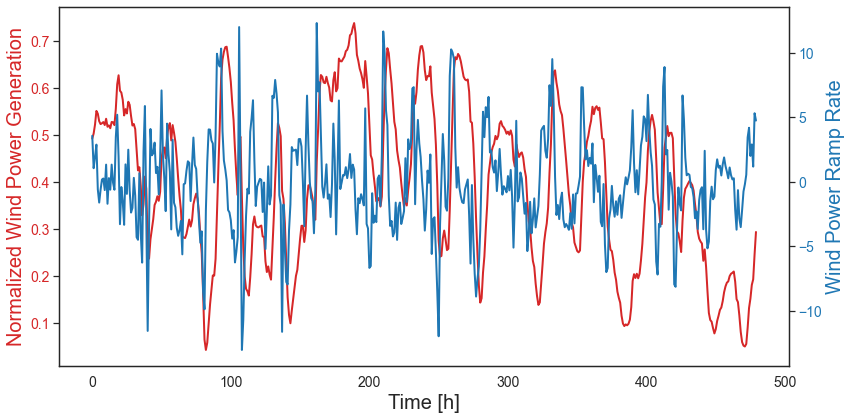

In [6]:
sns.set_theme(style="white")

fig, ax1 = plt.subplots(figsize=(12, 6))
plt.tick_params(axis='x', labelsize=14)

color = 'tab:red'
ax1.set_xlabel('Time [h]', fontsize=20)
ax1.set_ylabel('Normalized Wind Power Generation', color=color, fontsize=20)
ax1.plot(wind_df['Total Wind Output'][:480], linewidth=2, label='Wind Power Generation', color=color)
ax1.tick_params(axis='y', labelcolor=color, labelsize=14)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_xlabel('Time [h]', fontsize=20)
ax2.set_ylabel('Wind Power Ramp Rate', color=color, fontsize=20)
ax2.plot(wind_df['MW % change'][:480], linewidth=2, label='Wind Power Ramp Rate', color=color)
ax2.tick_params(axis='y', labelcolor=color, labelsize=14)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()
fig.savefig('Gen_vs_Ramp_signal.png', dpi=1000, bbox_inches="tight")

In [6]:
#from tensorflow.keras.layers import preprocessing
#from tensorflow.keras import preprocessing
import sklearn

wind_df = wind_df.reset_index(drop=True)
#std_scaler = sklearn.preprocessing.StandardScaler()
#std_scaler_load = sklearn.preprocessing.StandardScaler()
#std_scaler_ramp = sklearn.preprocessing.StandardScaler()

std_scaler = sklearn.preprocessing.MinMaxScaler()
std_scaler_load = sklearn.preprocessing.MinMaxScaler()
std_scaler_ramp = sklearn.preprocessing.MinMaxScaler()

wind_df[['Total Wind Output']] = std_scaler.fit_transform(wind_df[['Total Wind Output']])
wind_df[['MW % change']] = std_scaler_ramp.fit_transform(wind_df[['MW % change']])
#wind_df[['Wind Change, % of Load', 'Wind Change']] = std_scaler_ramp.fit_transform(wind_df[['Wind Change, % of Load', 'Wind Change']])
wind_df = wind_df.iloc[:-1,:]
wind_df

Year  MW % change  Total Wind Output
0      2020     0.620197           0.644724
1      2020     0.544580           0.658617
2      2020     0.570751           0.683924
3      2020     0.599594           0.721813
4      2020     0.495246           0.714187
...     ...          ...                ...
35058  2023     0.774643           0.484984
35059  2023     0.735512           0.582157
35060  2023     0.601593           0.620917
35061  2023     0.536583           0.631322
35062  2023     0.454969           0.606127

[35063 rows x 3 columns]

In [7]:
ramp_df = pd.DataFrame(wind_df)
ramp_df.columns=['Year', 'Wind Change', 'Wind Output']
ramp_df

Year  Wind Change  Wind Output
0      2020     0.620197     0.644724
1      2020     0.544580     0.658617
2      2020     0.570751     0.683924
3      2020     0.599594     0.721813
4      2020     0.495246     0.714187
...     ...          ...          ...
35058  2023     0.774643     0.484984
35059  2023     0.735512     0.582157
35060  2023     0.601593     0.620917
35061  2023     0.536583     0.631322
35062  2023     0.454969     0.606127

[35063 rows x 3 columns]

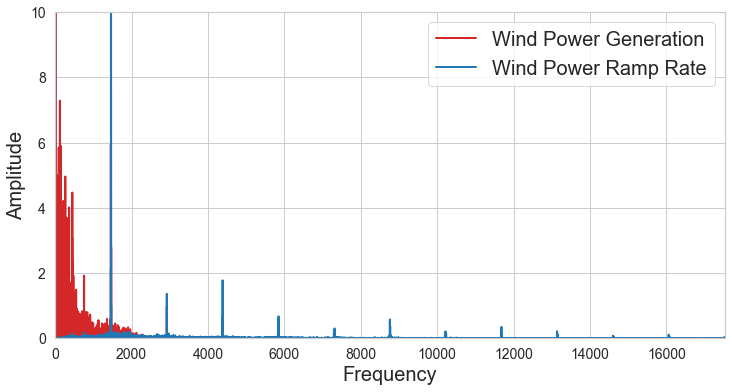

In [9]:
signal = np.fft.fft(ramp_df['Wind Output'])
signal = signal ** 2 / len(signal)

signal2 = np.fft.fft(ramp_df['Wind Change'])
signal2 = signal2 ** 2 / len(signal2)

sns.set_theme(style="whitegrid")
f, ax = plt.subplots(figsize=(12, 6))
plt.plot(abs(signal), linewidth=2, label='Wind Power Generation', color='tab:red')
plt.plot(abs(signal2), linewidth=2, label='Wind Power Ramp', color='tab:blue')
plt.xlabel('Frequency', fontsize=20)
plt.xlim(0, int(len(signal)/2))
plt.ylabel('Amplitude', fontsize=20)
plt.ylim(0, 10)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.legend(labels=['Wind Power Generation', 'Wind Power Ramp Rate'], loc="upper right", fontsize=20)
plt.show()
f.savefig('Gen_vs_Ramp_FFT.png', dpi=1000, bbox_inches="tight")

## Common Definitions

In [8]:
def create_dataset(dataset, timesteps, output_timesteps):
    dataX, dataY = [], []
    for i in range(len(dataset) - timesteps -output_timesteps - 1):
        a = dataset[i:(i + timesteps), :]
        dataX.append(a)
        dataY.append(dataset[(i + timesteps):(i+timesteps+output_timesteps), :])
    return np.array(dataX), np.array(dataY)

def svdadd(X, start, end, b_size):
    dec_x = X[start:end, :, :]
    U, S, Vh = svd(dec_x.reshape(b_size, -1), full_matrices=True)

    high_sig = np.matmul(np.matmul(U[:,:high_ind], np.diag(S[0:high_ind])), Vh[:high_ind,:])
    low_sig = X[:dec_num, :, :].reshape(b_size,-1)-high_sig

    rec_x = np.zeros((b_size, b_size, high_ind))
    
    #print(sum(S[0:high_ind])/sum(S))
    
    for i in range(high_ind):
        rec_x[:,:,i] = np.matmul((U[:,i]*S[i]).reshape(-1,1), Vh[i,:].reshape(1,-1))    
    return rec_x, low_sig

In [9]:
from sklearn.model_selection import train_test_split
from numpy.linalg import svd
import gc

def MAEMS(y_true, y_pred):
    return K.mean((K.abs(y_pred - y_true))*K.square(y_true))*100

def MAEMD(y_true, y_pred):
    return K.mean((K.abs(y_pred - y_true))*K.square(y_true-K.mean(y_true)))*100

def mse_mae(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true))+K.mean(K.abs(y_pred - y_true))

from keras.layers.advanced_activations import PReLU

## Wind Generation Forecasting

In [10]:
norm_df = np.array(wind_df.iloc[:,2]).reshape(-1,1)
timesteps = 24*7
output_timesteps = 24
num_features = 1
X, Y = create_dataset(norm_df, timesteps, output_timesteps)
b_size = timesteps

In [11]:
dec_num = timesteps
high_ind = 35

addX = np.zeros((X.shape[0], dec_num, high_ind+1))

for k in range(X.shape[0]//dec_num):
    rec_x, low_sig = svdadd(X, k*dec_num, (k+1)*dec_num, b_size)
    addX[k*dec_num:k*dec_num+dec_num,:, :-1] = rec_x
    addX[k*dec_num:k*dec_num+dec_num,:, -1] = low_sig
    
rec_x, low_sig = svdadd(X, X.shape[0]-dec_num, X.shape[0], b_size)
addX[X.shape[0]-dec_num:X.shape[0], :, :-1] = rec_x
addX[X.shape[0]-dec_num:X.shape[0],:, -1] = low_sig

addX_det = addX[:, :, :-1]
addX_det = np.sum(addX_det, axis=2)
X = np.concatenate([X, addX], axis=2)
num_features = X.shape[2]

In [12]:
a = np.zeros((168, 37))
for i in range(X.shape[2]):
    a[:,i] = std_scaler.inverse_transform(X[0,:,i].reshape(-1,1)).reshape(-1)

### Figures

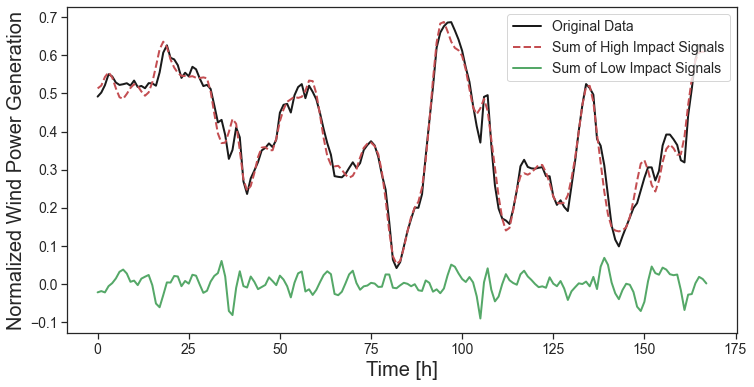

In [30]:
sns.set_theme(style="ticks")
#sns.set(font_scale=2)

f, ax = plt.subplots(figsize=(12, 6))

plt.rcParams.update({'font.size': 100})
plt.plot(a[:,0], 'k', linewidth=2, label='Original Data')
plt.plot(a[:,0]-a[:,36], 'r--', linewidth=2, label='Sum of High Impact Signals')
plt.plot(a[:,36], 'g', linewidth=2, label='Sum of Low Impact Signals')

plt.legend(loc=1, fontsize=14)
plt.xlabel('Time [h]', fontsize=20)
plt.ylabel('Normalized Wind Power Generation', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()
f.savefig('Decomposed_Data.png', dpi=1000, bbox_inches="tight")
#f.savefig('Decomposed_Data.eps', dpi=1000, bbox_inches="tight")

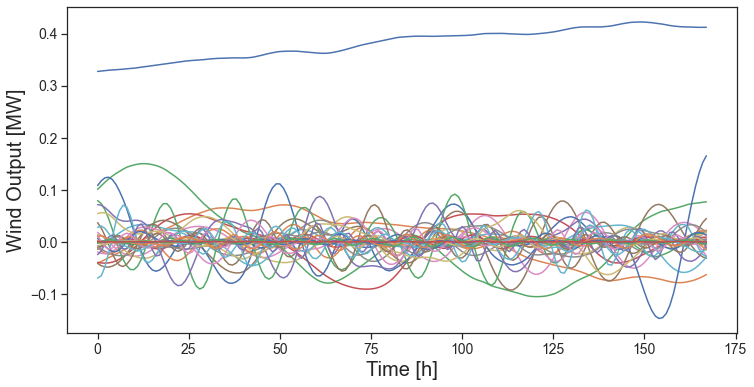

In [31]:
sns.set_theme(style="ticks")
f, ax = plt.subplots(figsize=(12, 6))
for i in range(1,35):
    plt.plot(a[:,i])
plt.xlabel('Time [h]', fontsize=20)
plt.ylabel('Wind Output [MW]', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()
f.savefig('Decomposed_Data2.png', dpi=1000, bbox_inches="tight")
#f.savefig('Decomposed_Data2.eps', dpi=1000, bbox_inches="tight")

In [34]:
X, Y = create_dataset(norm_df, timesteps, output_timesteps)

dec_x = X[0:168, :, :]
U, S, Vh = svd(dec_x.reshape(b_size, -1), full_matrices=True)
x = np.arange(168)
sumS = 0
sumlist = []
for i in range(S.shape[0]):
    sumS += S[i]/sum(S)
    sumlist.append(sumS)

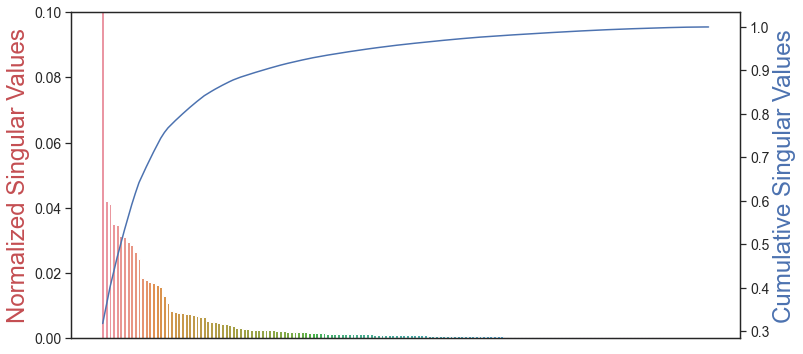

In [39]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()

ax1 = sns.barplot(x, S/sum(S), ax=ax1)
ax2 = sns.lineplot(x, np.array(sumlist), ax=ax2, linewidth=1.5)

ax1.set_ylabel('Normalized Singular Values', color='r', fontsize = "24")
ax2.set_ylabel('Cumulative Singular Values', color='b', fontsize = "24")

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim(0, 0.1)

ax1.set_xticks([])
ax2.set_xticks([])

fig.savefig('Singular_Value.png', dpi=1000, bbox_inches="tight")
#fig.savefig('Singular_Value.eps', dpi=1000, bbox_inches="tight")

## Load and Test Pre-trained Basic Model

In [13]:
trvaX, teX, trvaY, teY = train_test_split(X, Y, test_size=0.1, shuffle=False)
trvaY = trvaY.reshape(-1,output_timesteps)
teY = teY.reshape(-1,output_timesteps)
trvaX.shape, trvaY.shape, teX.shape, teY.shape

((31383, 168, 37), (31383, 24), (3487, 168, 37), (3487, 24))

In [14]:
with tf.device('/gpu:0'):
    wind_model = keras.models.load_model('Basic Model Final.h5', custom_objects={'MAEMS': MAEMS})
    winder_model = keras.models.load_model('Error Learning Model.h5', custom_objects={'mse_mae': mse_mae})
    gc.collect()
    trainPredict = wind_model.predict(trvaX, batch_size=b_size)
    testPredict = wind_model.predict(teX, batch_size=b_size)

In [15]:
def npMAEMS(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true))*100
def npMAEMD(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true-np.mean(y_true)))*100
def npMSE(y_true, y_pred):
    return np.mean(np.square(-y_true+y_pred))
def npMAE(y_true, y_pred):
    return np.mean(abs(-y_true+y_pred))

In [23]:
travaY = trvaY.reshape(-1)
trPredict = trainPredict.reshape(-1)
testY = teY.reshape(-1)
tePredict = testPredict.reshape(-1)

In [24]:
npMSE(trPredict, travaY), npMAE(trPredict, travaY), npMAEMS(trPredict, travaY), npMSE(tePredict, testY), npMAE(tePredict, testY), npMAEMS(tePredict, testY)

(0.004832750338121858,
 0.04636262627781242,
 0.9712366981963528,
 0.02565812209567252,
 0.12463339676994056,
 2.652095543019863)

In [25]:
trPredict = trPredict[(travaY>0.8)]
travaY = travaY[(travaY>0.8)]
tePredict = tePredict[(testY>0.8)]
testY = testY[(testY>0.8)]
npMSE(trPredict, travaY), npMAE(trPredict, travaY), npMAEMS(trPredict, travaY), npMSE(tePredict, testY), npMAE(tePredict, testY), npMAEMS(tePredict, testY)

(0.001257993882897658,
 0.028563551608590802,
 1.8860634864953238,
 0.04266651301905203,
 0.16662918083229836,
 5.724949306123013)

In [14]:
errors = trainPredict - trvaY
prediction = trainPredict

In [15]:
norm_df2 = pd.DataFrame(norm_df).iloc[timesteps:trvaX.shape[0]+timesteps, :]
norm_df2.columns = ['Normalized Wind']
norm_df2 = norm_df2.reset_index(drop=True)
norm_df2.shape

(31383, 1)

## Load and Test Pre-trained FFEL Model

In [16]:
Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12','Prediction13', 'Prediction14','Prediction15','Prediction16','Prediction17','Prediction18','Prediction19','Prediction20','Prediction21','Prediction22','Prediction23','Prediction24']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12','Error13', 'Error14','Error15','Error16','Error17','Error18','Error19','Error20','Error21','Error22','Error23','Error24']

pr_df = pd.DataFrame(prediction, columns=Prindex)
er_df = pd.DataFrame(errors, columns=Erindex)
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2

Normalized Wind  Prediction1  Prediction2  Prediction3  Prediction4  \
0             0.799339     0.779579     0.780941     0.776819     0.770332   
1             0.817166     0.764733     0.772070     0.774594     0.772313   
2             0.800019     0.763869     0.774328     0.782984     0.784131   
3             0.787147     0.745106     0.765642     0.785137     0.793927   
4             0.751347     0.737385     0.765438     0.790111     0.802796   
...                ...          ...          ...          ...          ...   
31378         0.371249     0.402742     0.361596     0.321930     0.289572   
31379         0.315295     0.333867     0.317358     0.303403     0.299089   
31380         0.263315     0.288536     0.296026     0.306061     0.326310   
31381         0.246790     0.262669     0.286098     0.314670     0.351921   
31382         0.253414     0.274413     0.316492     0.359062     0.406807   

       Prediction5  Prediction6  Prediction7  Prediction8  Prediction9  ...  \
0         0.769614     0.772137     0.771160     0.790148     0.800323  ...   
1         0.774626     0.780993     0.780714     0.798708     0.809025  ...   
2         0.785576     0.793881     0.791410     0.805422     0.815697  ...   
3         0.798366     0.809529     0.806618     0.817048     0.827832  ...   
4         0.806693     0.817312     0.814173     0.821519     0.835360  ...   
...            ...          ...          ...          ...          ...  ...   
31378     0.283192     0.288688     0.313892     0.362662     0.421016  ...   
31379     0.308505     0.330925     0.362386     0.412068     0.464874  ...   
31380     0.355649     0.390273     0.426094     0.470712     0.510744  ...   
31381     0.399955     0.445189     0.485191     0.526435     0.555643  ...   
31382     0.461230     0.506803     0.542168     0.575328     0.593149  ...   

        Error15   Error16   Error17   Error18   Error19   Error20   Error21  \
0     -0.003799 -0.012040 -0.004693 -0.009210 -0.029859 -0.038173 -0.060760   
1     -0.007667 -0.002270 -0.001317 -0.020459 -0.016934 -0.042657 -0.064202   
2     -0.004643 -0.005697 -0.018947 -0.015392 -0.028357 -0.055118 -0.043005   
3     -0.004882 -0.022702 -0.012084 -0.027878 -0.040088 -0.033474  0.004316   
4     -0.026391 -0.024375 -0.032330 -0.051514 -0.026563  0.007080 -0.000883   
...         ...       ...       ...       ...       ...       ...       ...   
31378  0.114420  0.126155  0.020111 -0.033081 -0.008648 -0.013253 -0.037107   
31379  0.128577  0.029052 -0.018337 -0.002811  0.002181 -0.025000 -0.001851   
31380  0.013762 -0.025961 -0.005152 -0.009236 -0.020131  0.002315  0.001120   
31381 -0.053965 -0.035518 -0.038928 -0.065040 -0.029917 -0.027642  0.027935   
31382 -0.020048 -0.031143 -0.059476 -0.039642 -0.031822  0.029473  0.095377   

        Error22   Error23   Error24  
0     -0.088310 -0.062417 -0.003380  
1     -0.057680 -0.005597  0.002320  
2     -0.012975 -0.011321 -0.004619  
3     -0.016100 -0.014654 -0.019749  
4     -0.015798 -0.021841 -0.020402  
...         ...       ...       ...  
31378 -0.012926 -0.004429  0.061363  
31379 -0.008394  0.052539  0.125931  
31380  0.049849  0.120617  0.177512  
31381  0.087677  0.137588  0.178664  
31382  0.139943  0.170866  0.173554  

[31383 rows x 49 columns]

In [17]:
norm_df2 = np.array(norm_df2)
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
Xe.shape

(31213, 168, 49)

In [18]:
trvaXe = Xe
trvaYe = Ye[:,:,-24:].reshape(-1,24)

In [19]:
with tf.device('/gpu:0'):
    trainerPredict = winder_model.predict(trvaXe, batch_size=b_size)

In [20]:
addtrainPredict = trainPredict[timesteps:-2,:]-trainerPredict
#addtestPredict = testPredict[timesteps:-2,:]-testerPredict

In [21]:
errors = testPredict - teY
prediction = testPredict

norm_df2 = pd.DataFrame(norm_df).iloc[trvaX.shape[0]+timesteps:trvaX.shape[0]+timesteps+teY.shape[0], :]
norm_df2.columns = ['Normalized Wind']
norm_df2 = norm_df2.reset_index(drop=True)

Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12','Prediction13', 'Prediction14','Prediction15','Prediction16','Prediction17','Prediction18','Prediction19','Prediction20','Prediction21','Prediction22','Prediction23','Prediction24']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12','Error13', 'Error14','Error15','Error16','Error17','Error18','Error19','Error20','Error21','Error22','Error23','Error24']

pr_df = pd.DataFrame(prediction, columns=Prindex)
er_df = pd.DataFrame(errors, columns=Erindex)

norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2 = np.array(norm_df2)
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
teXe = Xe
teYe = Ye[:,:,-24:].reshape(-1,24)

In [22]:
with tf.device('/gpu:0'):
    #trainerPredict = winder_model.predict(trvaXe, batch_size=b_size)
    testerPredict = winder_model.predict(teXe, batch_size=b_size)

In [23]:
#addtrainPredict = trainPredict[timesteps:-2,:]-trainerPredict
addtestPredict = testPredict[timesteps:-2,:]-testerPredict

In [24]:
print('Error Train Score > MSE == ', (np.mean(np.square(trvaY[timesteps:-2,:]-trainPredict[timesteps:-2,:]))), ' MAE == ', mean_absolute_error(trvaY[timesteps:-2,:], trainPredict[timesteps:-2,:]), ' MAPE == ', mean_absolute_percentage_error(trvaY[timesteps:-2,:], trainPredict[timesteps:-2,:]), )
print('Error Train Score > MSE == ', (np.mean(np.square(trvaY[timesteps:-2,:]-addtrainPredict))), ' MAE == ', mean_absolute_error(trvaY[timesteps:-2,:], addtrainPredict), ' MAPE == ', mean_absolute_percentage_error(trvaY[timesteps:-2,:], addtrainPredict))
print('Error Test Score > MSE == ', (np.mean(np.square(teY[timesteps:-2,:]-testPredict[timesteps:-2,:]))), ' MAE == ', mean_absolute_error(teY[timesteps:-2,:], testPredict[timesteps:-2,:]), ' MAPE == ', mean_absolute_percentage_error(teY[timesteps:-2,:], testPredict[timesteps:-2,:]), ' MAEMS == ', np.mean((abs(testPredict[timesteps:-2,:] - teY[timesteps:-2,:]))*np.square(teY[timesteps:-2,:]-np.mean(teY[timesteps:-2,:])))*100)
print('Error Test Score > MSE == ', (np.mean(np.square(teY[timesteps:-2,:]-addtestPredict))), ' MAE == ', mean_absolute_error(teY[timesteps:-2,:], addtestPredict), ' MAPE == ', mean_absolute_percentage_error(teY[timesteps:-2,:], addtestPredict), ' MAEMS == ', np.mean((abs(addtestPredict - teY[timesteps:-2,:]))*np.square(teY[timesteps:-2,:]-np.mean(teY[timesteps:-2,:])))*100)

Error Train Score > MSE ==  0.004846902975277587  MAE ==  0.04642789456639893  MAPE ==  inf
Error Train Score > MSE ==  0.00016115637799270303  MAE ==  0.009377527472793004  MAPE ==  inf
Error Test Score > MSE ==  0.025935954418349262  MAE ==  0.12522899449503364  MAPE ==  67.56061405396892  MAEMS ==  0.6148162863605252
Error Test Score > MSE ==  0.003354591755936191  MAE ==  0.03987483257454832  MAPE ==  15.808386207424372  MAEMS ==  0.20073151744590434


In [25]:
result_tr = np.concatenate([addtrainPredict.reshape(-1,1), trvaY[timesteps:-2,:].reshape(-1,1), trvaY[timesteps:-2,:].reshape(-1,1)-addtrainPredict.reshape(-1,1), trainPredict[timesteps:-2,:].reshape(-1,1)], axis=1)
result_te = np.concatenate([addtestPredict.reshape(-1,1), teY[timesteps:-2,:].reshape(-1,1), teY[timesteps:-2,:].reshape(-1,1)-addtestPredict.reshape(-1,1), testPredict[timesteps:-2,:].reshape(-1,1)], axis=1)

result_tr_df = pd.DataFrame(result_tr, columns=['Predicted Value','Real Value','Forecasting Error', 'Initial Predicted Value'])
result_te_df = pd.DataFrame(result_te, columns=['Predicted Value','Real Value','Forecasting Error', 'Initial Predicted Value'])

In [26]:
teY[timesteps:-2,:].reshape(-1,1).shape, addtestPredict.reshape(-1,1).shape

((79608, 1), (79608, 1))

In [27]:
result_te_df

Predicted Value  Real Value  Forecasting Error  Initial Predicted Value
0             0.480779    0.461890          -0.018888                 0.432659
1             0.512739    0.508118          -0.004621                 0.464848
2             0.563209    0.560342          -0.002868                 0.483715
3             0.579102    0.597191           0.018089                 0.501839
4             0.529399    0.557622           0.028223                 0.517020
...                ...         ...                ...                      ...
79603         0.237754    0.293595           0.055841                 0.402840
79604         0.250278    0.311174           0.060896                 0.421850
79605         0.258552    0.341026           0.082474                 0.436025
79606         0.269123    0.370742           0.101619                 0.451646
79607         0.322833    0.484984           0.162151                 0.477331

[79608 rows x 4 columns]

In [28]:
error_tr_FFEL = trvaY[timesteps:-2,:].reshape(-1,1)-addtrainPredict.reshape(-1,1)
error_tr_basic = trvaY[timesteps:-2,:].reshape(-1,1)-trainPredict[timesteps:-2,:].reshape(-1,1)
error_te_FFEL = teY[timesteps:-2,:].reshape(-1,1)-addtestPredict.reshape(-1,1)
error_te_basic = teY[timesteps:-2,:].reshape(-1,1)-testPredict[timesteps:-2,:].reshape(-1,1)

In [29]:
np.mean(error_tr_FFEL), np.var(error_tr_FFEL), np.mean(error_tr_basic), np.var(error_tr_basic), np.mean(error_te_FFEL),np.var(error_te_FFEL), np.mean(error_te_basic), np.var(error_te_basic)

(-0.00045960112505240123,
 0.00016094514479855353,
 -0.012883823810480295,
 0.004680910059298086,
 0.023610151398544752,
 0.002797152506873985,
 -0.04065087568554847,
 0.024283460724347353)

In [30]:
result_tr_df.to_csv('training_result_df.csv')
result_te_df.to_csv('test_result_df.csv')

# Ramp Rate Forecasting

In [16]:
norm_df = np.array(wind_df.iloc[:,1]).reshape(-1,1)
timesteps = 24*7
output_timesteps = 24
num_features = 1
X, Y = create_dataset(norm_df, timesteps, output_timesteps)
b_size = timesteps

In [17]:
X.shape, Y.shape

((34870, 168, 1), (34870, 24, 1))

In [18]:
dec_num = timesteps
high_ind = 35

addX = np.zeros((X.shape[0], dec_num, high_ind+1))

for k in range(X.shape[0]//dec_num):
    rec_x, low_sig = svdadd(X, k*dec_num, (k+1)*dec_num, b_size)
    addX[k*dec_num:k*dec_num+dec_num,:, :-1] = rec_x
    addX[k*dec_num:k*dec_num+dec_num,:, -1] = low_sig
    
rec_x, low_sig = svdadd(X, X.shape[0]-dec_num, X.shape[0], b_size)
addX[X.shape[0]-dec_num:X.shape[0], :, :-1] = rec_x
addX[X.shape[0]-dec_num:X.shape[0],:, -1] = low_sig

addX_det = addX[:, :, :-1]
addX_det = np.sum(addX_det, axis=2)
X = np.concatenate([X, addX], axis=2)
num_features = X.shape[2]

### Figures

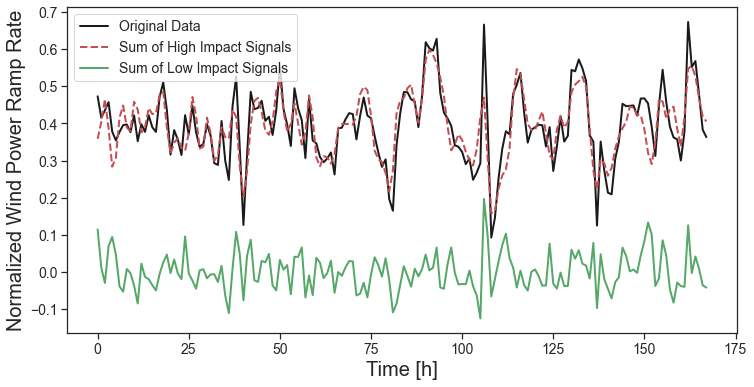

In [43]:
a = np.zeros((168, 37))

for i in range(X.shape[2]):
    a[:,i] = std_scaler.inverse_transform(X[0,:,i].reshape(-1,1)).reshape(-1)
    
sns.set_theme(style="ticks")
#sns.set(font_scale=2)

f, ax = plt.subplots(figsize=(12, 6))

plt.rcParams.update({'font.size': 100})
plt.plot(a[:,0], 'k', linewidth=2, label='Original Data')
plt.plot(a[:,0]-a[:,36], 'r--', linewidth=2, label='Sum of High Impact Signals')
plt.plot(a[:,36], 'g', linewidth=2, label='Sum of Low Impact Signals')

plt.legend(loc="upper left", fontsize=14)
plt.xlabel('Time [h]', fontsize=20)
plt.ylabel('Normalized Wind Power Ramp Rate', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()
f.savefig('Ramp Decomposed_Data.png', dpi=1000, bbox_inches="tight")
#f.savefig('Decomposed_Data.eps', dpi=1000, bbox_inches="tight")

In [44]:
X, Y = create_dataset(norm_df, timesteps, output_timesteps)

dec_x = X[0:168, :, :]
U, S, Vh = svd(dec_x.reshape(b_size, -1), full_matrices=True)

sumS = 0
sumlist = []
for i in range(S.shape[0]):
    sumS += S[i]/sum(S)
    sumlist.append(sumS)

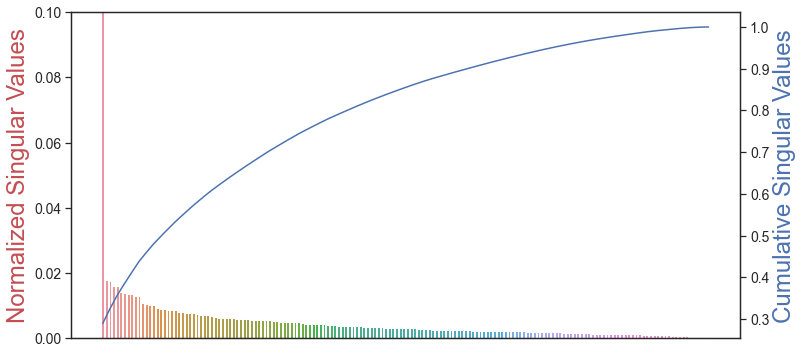

In [45]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()

ax1 = sns.barplot(x, S/sum(S), ax=ax1)
ax2 = sns.lineplot(x, np.array(sumlist), ax=ax2, linewidth=1.5)

ax1.set_ylabel('Normalized Singular Values', color='r', fontsize = "24")
ax2.set_ylabel('Cumulative Singular Values', color='b', fontsize = "24")

ax1.tick_params(axis='both', which='major', labelsize=14)
ax2.tick_params(axis='both', which='major', labelsize=14)
ax1.set_ylim(0, 0.1)

ax1.set_xticks([])
ax2.set_xticks([])

fig.savefig('Ramp Singular_Value.png', dpi=1000, bbox_inches="tight")
#fig.savefig('Singular_Value.eps', dpi=1000, bbox_inches="tight")

## Load and Test Pre-trained Basic Model

In [19]:
trvaX, teX, trvaY, teY = train_test_split(X, Y, test_size=0.1, shuffle=False)
trvaY = trvaY.reshape(-1,output_timesteps)
teY = teY.reshape(-1,output_timesteps)
trvaX.shape, trvaY.shape, teX.shape, teY.shape

((31383, 168, 37), (31383, 24), (3487, 168, 37), (3487, 24))

In [20]:
gc.collect()

4187

In [21]:
with tf.device('/gpu:0'):
    ramp_model = keras.models.load_model('Basic Ramp Model Final.h5', custom_objects={'MAEMD': MAEMD})
    ramper_model = keras.models.load_model('Error Learning Ramp Model.h5', custom_objects={'mse_mae': mse_mae})
    gc.collect()
    trainPredict = ramp_model.predict(trvaX, batch_size=b_size)
    testPredict = ramp_model.predict(teX, batch_size=b_size)

In [22]:
def npMAEMS(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true))*100
def npMAEMD(y_true, y_pred):
    return np.mean((abs(y_pred - y_true))*np.square(y_true-np.mean(y_true)))*100
def npMSE(y_true, y_pred):
    return np.mean(np.square(-y_true+y_pred))
def npMAE(y_true, y_pred):
    return np.mean(abs(-y_true+y_pred))

In [37]:
errors = trainPredict - trvaY
prediction = trainPredict

In [38]:
norm_df2 = pd.DataFrame(norm_df).iloc[timesteps:trvaX.shape[0]+timesteps, :]
norm_df2.columns = ['Normalized Wind']
norm_df2 = norm_df2.reset_index(drop=True)
norm_df2.shape

(31383, 1)

## Load and Test Pre-trained FFEL Model

In [39]:
Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12','Prediction13', 'Prediction14','Prediction15','Prediction16','Prediction17','Prediction18','Prediction19','Prediction20','Prediction21','Prediction22','Prediction23','Prediction24']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12','Error13', 'Error14','Error15','Error16','Error17','Error18','Error19','Error20','Error21','Error22','Error23','Error24']

pr_df = pd.DataFrame(prediction, columns=Prindex)
er_df = pd.DataFrame(errors, columns=Erindex)
norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2

Normalized Wind  Prediction1  Prediction2  Prediction3  Prediction4  \
0             0.508387     0.452832     0.445444     0.478672     0.457846   
1             0.553601     0.401825     0.435133     0.455205     0.447544   
2             0.473418     0.501539     0.460362     0.455424     0.495849   
3             0.483218     0.399785     0.407836     0.523190     0.570356   
4             0.430654     0.351464     0.398090     0.494415     0.491335   
...                ...          ...          ...          ...          ...   
31378         0.306601     0.188043     0.313282     0.384366     0.467638   
31379         0.384449     0.266191     0.378605     0.453691     0.549322   
31380         0.393560     0.360367     0.461236     0.517963     0.579177   
31381         0.474845     0.400283     0.520308     0.543957     0.570731   
31382         0.527916     0.513230     0.555980     0.595293     0.639676   

       Prediction5  Prediction6  Prediction7  Prediction8  Prediction9  ...  \
0         0.422367     0.454038     0.489488     0.414239     0.401638  ...   
1         0.464193     0.513478     0.516320     0.442624     0.482226  ...   
2         0.533033     0.474907     0.458554     0.480625     0.574443  ...   
3         0.519403     0.470779     0.524971     0.615553     0.658186  ...   
4         0.433095     0.470539     0.618232     0.631281     0.593849  ...   
...            ...          ...          ...          ...          ...  ...   
31378     0.544971     0.548749     0.616679     0.698686     0.647792  ...   
31379     0.574065     0.580878     0.608275     0.636248     0.675216  ...   
31380     0.619581     0.625144     0.605712     0.603940     0.671353  ...   
31381     0.633727     0.620715     0.605085     0.642436     0.635331  ...   
31382     0.634352     0.615172     0.640662     0.621131     0.501674  ...   

        Error15   Error16   Error17   Error18   Error19   Error20   Error21  \
0     -0.107563 -0.128024 -0.063147  0.047078  0.123159  0.155805  0.023922   
1     -0.185531 -0.152406 -0.067906  0.076335  0.157675  0.016830 -0.099808   
2     -0.162199 -0.117919 -0.044415  0.078382  0.011220 -0.055220 -0.071860   
3     -0.196227 -0.115445 -0.007640 -0.012828 -0.004049  0.030868 -0.017285   
4     -0.117576 -0.020615 -0.026900 -0.012857  0.064992  0.035994 -0.100823   
...         ...       ...       ...       ...       ...       ...       ...   
31378  0.013430 -0.045545 -0.207041 -0.110265 -0.007679 -0.062399 -0.227882   
31379 -0.043666 -0.276867 -0.150235  0.036523 -0.011349 -0.153471 -0.130039   
31380 -0.228237 -0.121724  0.050490  0.025452 -0.102912 -0.017198 -0.017482   
31381 -0.171333 -0.005274 -0.007570 -0.075248  0.009383  0.015877  0.062002   
31382  0.052549 -0.042311 -0.126247  0.007080  0.030549  0.085665 -0.003904   

        Error22   Error23   Error24  
0     -0.039367  0.018223  0.066967  
1     -0.025892 -0.009454 -0.094085  
2     -0.040350 -0.093598 -0.012892  
3     -0.137377 -0.091552 -0.030570  
4     -0.062403 -0.070914 -0.070197  
...         ...       ...       ...  
31378 -0.151968 -0.041926  0.008078  
31379 -0.077594  0.049974 -0.049636  
31380  0.047756 -0.035357 -0.089029  
31381 -0.067285 -0.060868 -0.008630  
31382 -0.035553  0.019972  0.016207  

[31383 rows x 49 columns]

In [40]:
norm_df2 = np.array(norm_df2)
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
Xe.shape

(31213, 168, 49)

In [41]:
trvaXe = Xe
trvaYe = Ye[:,:,-24:].reshape(-1,24)

In [42]:
with tf.device('/gpu:0'):
    trainerPredict = ramper_model.predict(trvaXe, batch_size=b_size)

In [43]:
addtrainPredict = trainPredict[timesteps:-2,:]-trainerPredict
#addtestPredict = testPredict[timesteps:-2,:]-testerPredict

In [44]:
errors = testPredict - teY
prediction = testPredict

norm_df2 = pd.DataFrame(norm_df).iloc[trvaX.shape[0]+timesteps:trvaX.shape[0]+timesteps+teY.shape[0], :]
norm_df2.columns = ['Normalized Wind']
norm_df2 = norm_df2.reset_index(drop=True)

Prindex = ['Prediction1', 'Prediction2','Prediction3','Prediction4','Prediction5','Prediction6','Prediction7','Prediction8','Prediction9','Prediction10','Prediction11','Prediction12','Prediction13', 'Prediction14','Prediction15','Prediction16','Prediction17','Prediction18','Prediction19','Prediction20','Prediction21','Prediction22','Prediction23','Prediction24']
Erindex = ['Error1', 'Error2','Error3','Error4','Error5','Error6','Error7','Error8','Error9','Error10','Error11','Error12','Error13', 'Error14','Error15','Error16','Error17','Error18','Error19','Error20','Error21','Error22','Error23','Error24']

pr_df = pd.DataFrame(prediction, columns=Prindex)
er_df = pd.DataFrame(errors, columns=Erindex)

norm_df2 = pd.concat([norm_df2, pr_df, er_df],axis=1)
norm_df2 = np.array(norm_df2)
output_timesteps = 1
Xe, Ye = create_dataset(norm_df2, timesteps, output_timesteps)
teXe = Xe
teYe = Ye[:,:,-24:].reshape(-1,24)

In [45]:
with tf.device('/gpu:0'):
    #trainerPredict = winder_model.predict(trvaXe, batch_size=b_size)
    testerPredict = ramper_model.predict(teXe, batch_size=b_size)

In [46]:
#addtrainPredict = trainPredict[timesteps:-2,:]-trainerPredict
addtestPredict = testPredict[timesteps:-2,:]-testerPredict

In [47]:
print('Error Train Score > MSE == ', (np.mean(np.square(trvaY[timesteps:-2,:]-trainPredict[timesteps:-2,:]))), ' MAE == ', mean_absolute_error(trvaY[timesteps:-2,:], trainPredict[timesteps:-2,:]), ' MAPE == ', mean_absolute_percentage_error(trvaY[timesteps:-2,:], trainPredict[timesteps:-2,:]), )
print('Error Train Score > MSE == ', (np.mean(np.square(trvaY[timesteps:-2,:]-addtrainPredict))), ' MAE == ', mean_absolute_error(trvaY[timesteps:-2,:], addtrainPredict), ' MAPE == ', mean_absolute_percentage_error(trvaY[timesteps:-2,:], addtrainPredict))
print('Error Test Score > MSE == ', (np.mean(np.square(teY[timesteps:-2,:]-testPredict[timesteps:-2,:]))), ' MAE == ', mean_absolute_error(teY[timesteps:-2,:], testPredict[timesteps:-2,:]), ' MAPE == ', mean_absolute_percentage_error(teY[timesteps:-2,:], testPredict[timesteps:-2,:]), ' MAEMS == ', np.mean((abs(testPredict[timesteps:-2,:] - teY[timesteps:-2,:]))*np.square(teY[timesteps:-2,:]-np.mean(teY[timesteps:-2,:])))*100)
print('Error Test Score > MSE == ', (np.mean(np.square(teY[timesteps:-2,:]-addtestPredict))), ' MAE == ', mean_absolute_error(teY[timesteps:-2,:], addtestPredict), ' MAPE == ', mean_absolute_percentage_error(teY[timesteps:-2,:], addtestPredict), ' MAEMS == ', np.mean((abs(addtestPredict - teY[timesteps:-2,:]))*np.square(teY[timesteps:-2,:]-np.mean(teY[timesteps:-2,:])))*100)

Error Train Score > MSE ==  0.0071911842522257565  MAE ==  0.06500557938843311  MAPE ==  inf
Error Train Score > MSE ==  0.0007517385783175689  MAE ==  0.021197538887890822  MAPE ==  inf
Error Test Score > MSE ==  0.01025970561124347  MAE ==  0.08004770451571365  MAPE ==  16.1046124483836  MAEMS ==  0.09448454363246535
Error Test Score > MSE ==  0.0025434314962971705  MAE ==  0.03924433526905973  MAPE ==  7.950189817120407  MAEMS ==  0.039112515570334516


In [50]:
result_tr = np.concatenate([addtrainPredict.reshape(-1,1), trvaY[timesteps:-2,:].reshape(-1,1), trvaY[timesteps:-2,:].reshape(-1,1)-addtrainPredict.reshape(-1,1), trainPredict[timesteps:-2,:].reshape(-1,1)], axis=1)
result_te = np.concatenate([addtestPredict.reshape(-1,1), teY[timesteps:-2,:].reshape(-1,1), teY[timesteps:-2,:].reshape(-1,1)-addtestPredict.reshape(-1,1), testPredict[timesteps:-2,:].reshape(-1,1)], axis=1)

result_tr_df = pd.DataFrame(result_tr, columns=['Predicted Value','Real Value','Forecasting Error', 'Initial Predicted Value'])
result_te_df = pd.DataFrame(result_te, columns=['Predicted Value','Real Value','Forecasting Error', 'Initial Predicted Value'])

In [51]:
error_tr_FFEL = trvaY[timesteps:-2,:].reshape(-1,1)-addtrainPredict.reshape(-1,1)
error_tr_basic = trvaY[timesteps:-2,:].reshape(-1,1)-trainPredict[timesteps:-2,:].reshape(-1,1)
error_te_FFEL = teY[timesteps:-2,:].reshape(-1,1)-addtestPredict.reshape(-1,1)
error_te_basic = teY[timesteps:-2,:].reshape(-1,1)-testPredict[timesteps:-2,:].reshape(-1,1)

In [52]:
np.mean(error_tr_FFEL), np.var(error_tr_FFEL), np.mean(error_tr_basic), np.var(error_tr_basic), np.mean(error_te_FFEL),np.var(error_te_FFEL), np.mean(error_te_basic), np.var(error_te_basic)

(5.8241313532665895e-05,
 0.0007517351862669669,
 0.020960213500453417,
 0.006751853702241166,
 -0.0006100938668456297,
 0.002543059281770808,
 0.019956163860034272,
 0.009861457135234933)

In [53]:
result_tr_df.to_csv('training_ramp_result_df.csv')
result_te_df.to_csv('test_ramp_result_df.csv')